In [66]:
# import some stuff
import math
import time
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.svm import SVC

In [67]:
# These functions implement kernel PCA

# This function is just the radial kernel
def radial_dist(data):
    N = data.shape[0]
    euclid_dists = list()
    for i in range(0,N):
        for j in range(i+1,N):
            # Taking advantage of the fact that the distance
            # between a vector and itself if 0.
            euclid_dists.append(np.linalg.norm(data[i,:]-data[j,:]))
    sigma = np.var(euclid_dists)
    gamma = 1 / (2*sigma**2)
    radial_dists = np.full((N,N),1)
    for i in range(0,N):
        for j in range(i+1,N):
            # Taking advantage of the fact that the radial distance
            # between a vector and itself if 1.
            d = np.linalg.norm(data[i,:]-data[j,:])**2
            radial_dists[i,j]=radial_dists[j,i]=math.exp(-(gamma*d))
    return radial_dists

# This function takes:
#   a set of data
#   a kernel function, 
# and returns:
#   The kernel PCA representation of each data point
def kernel_pca_rep(data, func):
    N = data.shape[0]
    K = func(data)
    one_over_n = np.full((N,N), 1/N)
    K_tilde = (K - one_over_n @ K - K @ one_over_n + one_over_n @ K @ one_over_n)
    # Solve lambda @ alpha = K_tilde @ alpha
    lambdas, alphas = np.linalg.eig(K_tilde)
    # We want to normalise using (lambda (alpha @ alpha)) = 1
    # And remove eigenvectors whose eigenvalues are not positive
    remove_idx = list()
    for i in range(0,len(lambdas)):
        if lambdas[i] <= 0:
            remove_idx.append(i)
        else:
            alphas[i] = alphas[i] * math.sqrt(lambdas[i])
    for idx in remove_idx:
        np.delete(alphas,idx,axis=1)
        np.delete(lambdas,idx,axis=0)
    # We want to get the projections
    M = len(lambdas)
    pca_data = np.zeros((N,M))
    for idx in range(0,N):
        proj = np.zeros((1,M))
        for coord in range(0,M):
            proj[0,coord] = np.sum(alphas[:,coord] * K[:,idx])
        pca_data[idx,:] = proj.copy()
    return pca_data

In [175]:
# functions for visualisation, adapted from
# https://chrisalbon.com/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/
# https://www.geeksforgeeks.org/ml-non-linear-svm/
# I added the ability to plot the original data
# and transformed boundaries.

def versiontuple(v):
    return tuple(map(int, (v.split("."))))

def plot_decision_regions(ax, x, y, clf, nlca=None, M=None, resolution=0.2):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    

    # plot the decision surface
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    predict_from = np.array([xx1.ravel(), xx2.ravel()]).T
#     print("predict_from.shape",predict_from.shape)
    if nlca:
        predict_from = kernel_pca_rep(predict_from, nlca)
        Z = clf.predict(predict_from)
        Z = Z.reshape(xx1.shape)
#         print("xx1.shape",xx1.shape)
#         print("xx2.shape",xx2.shape)
#         print("Z.shape",Z.shape)
        ax.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    else:
        Z = clf.predict(predict_from)
        Z = Z.reshape(xx1.shape)
#         M = len(xx1.ravel())
#         xx1 =  xx1.ravel().reshape((M,1))
#         xx2 =  xx2.ravel().reshape((M,1))
#         print("xx1.shape",xx1.shape)
#         print("xx2.shape",xx2.shape)
#         print("Z.shape",Z.shape)
        ax.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=x[y == cl, 0], y=x[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

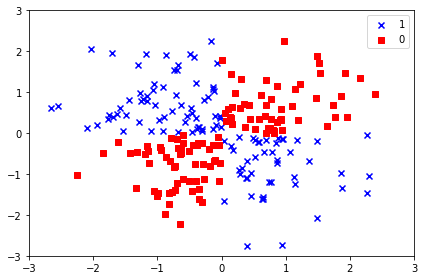

In [168]:
# Some synthetic data, code from
# https://chrisalbon.com/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/

np.random.seed(0)
X_xor = np.random.randn(225, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, 0)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == 0, 0],
            X_xor[y_xor == 0, 1],
            c='r',
            marker='s',
            label='0')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [169]:
# Get Radial PCA of the data
start_time = time.time()
pca_data = kernel_pca_rep(X_xor, radial_dist)
print(pca_data.shape)
print("--- %s seconds ---" % (time.time() - start_time), "to train perform radial PCA.")


/home/rachel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
/home/rachel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: ComplexWarning: Casting complex values to real discards the imaginary part


(225, 225)
--- 0.9043936729431152 seconds --- to train perform radial PCA.


In [181]:
# Train a radial SVM
start_time = time.time()
svm_radial = SVC(kernel='rbf', random_state=0, gamma=1, C=1)
svm_radial.fit(X_xor, y_xor) 
print("--- %s seconds ---" % (time.time() - start_time), "to train a radial SVM.")

# Train a linear SVM with radial pca
start_time = time.time()
svm_linear = SVC(kernel='linear', random_state=0, gamma=1, C=1)
svm_linear.fit(pca_data, y_xor) 
print("--- %s seconds ---" % (time.time() - start_time), "to train a linear SVM with radial PCA.")

--- 0.006208181381225586 seconds --- to train a radial SVM.
--- 0.03511762619018555 seconds --- to train a linear SVM with radial PCA.


xx1.shape (352, 353)
xx2.shape (352, 353)
Z.shape (352, 353)


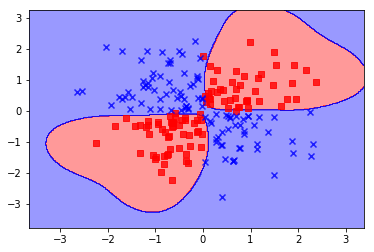

In [166]:
# Plot the radial SVM
fig1 = plt.subplot() 
plot_decision_regions(fig1, X_xor, y_xor, svm_radial, nlca=None, M=None, resolution=0.02)


/home/rachel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
/home/rachel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: ComplexWarning: Casting complex values to real discards the imaginary part


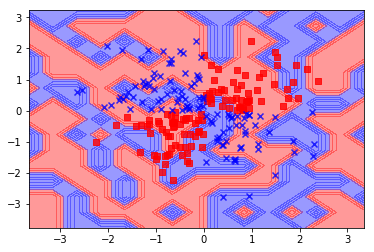

In [178]:

# Plot the linear SVM with radial pca
fig2 = plt.subplot() 
plot_decision_regions(fig2, X_xor, y_xor, svm_linear, nlca=radial_dist, M=pca_data.shape[0], resolution=0.5)

In [183]:
# Accuracy
radial_predict = svm_radial.predict(X_xor)
linear_predict = svm_linear.predict(pca_data)
acc_total = 0
acc_same = 0
for idx in range(0,len(radial_predict)):
    acc_total += 1
    if radial_predict[idx]==linear_predict[idx]:
        acc_same += 1
percentage = str(acc_same/acc_total * 100)

print("The two predictors have the same prediction",percentage+"% of the time.")

The two predictors have the same prediction 65.77777777777779% of the time.
